# Data curation for Safety Screen Targets

# Read data

In [49]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
print("job ok")

job ok


In [50]:
#genes = ['CHRM1', 'CHRM2', 'CHRM3', 'CYP2C9', 'CYP2D6', 'CYP3A4', 'HRH1', 'KCNH2', 'PIK3CG'] #PIK3CG - model file name problem
gene='PIK3CG' 

In [51]:
from atomsci.ddm.utils import model_retrain
import sys, os
import pandas as pd
%config Completer.use_jedi=False
print("Module 1")

Module 1


In [52]:
home_dir='/home/sarkart4/MoDaC/NCI_DOE_Archive/ATOM/Safety_Screen_Targets/'
#!ls $home_dir

In [53]:
train=pd.read_csv(os.path.join(home_dir, gene.upper()+'-ampl-1.1.0/'+gene.lower()+'_union_trainset_base_smiles.csv'))
train.head(2)

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,COc1cc(Nc2nc3ccccc3nc2NS(=O)(=O)c2cccnc2)cc(C(...,CHEMBL3652121,5.508638,NaN,1
1,CN(C)c1ccc(Nc2ccc3c(c2)N(c2nc4c(s2)C(=O)NC(C)(...,CHEMBL489596,7.619859,NaN,1


In [54]:
test=pd.read_csv(os.path.join(home_dir, gene.upper()+'-ampl-1.1.0/'+gene.lower()+'_union_testset_base_smiles.csv'))
test.head(2)

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,COc1cnc(Nc2cnc(Cl)c(NS(=O)(=O)N(C)C)c2)c(-c2nc...,BHEMPSVJQFJQIN-GETYNBQFNA-N,8.66,NaN,1
1,Cc1ccc(Nc2ncc(CN3CCN(S(C)(=O)=O)CC3)cc2-c2nc(C...,NRNPLKNQEHSDHU-JBVIFLSCNA-N,7.51,NaN,1


In [55]:
# locate the split file
split_file=[file for file in os.listdir(os.path.join(home_dir, gene.upper()+'-ampl-1.1.0/')) if file.startswith(gene.lower()+'_union_trainset_base_smiles_train_valid_test_')][0]
split=pd.read_csv(home_dir+gene.upper()+'-ampl-1.1.0/'+split_file)
split.head(2)

,cmpd_id,fold,subset
0,CHEMBL489596,0,train
1,ZCXQHOPHHNFUNN-UHFFFAOYSA-N,0,train


In [56]:
train.shape, test.shape, split.shape

((2611, 5), (428, 5), (2611, 3))

In [57]:
split.subset.value_counts()

train    2214
valid     391
test        6
Name: subset, dtype: int64

## before merging split_file and union_test files, there were very few number of testdata in test_file
## we are merging union_train, union_test and split_file to get train-validation-test split on overall data

In [58]:
# merge all info together and cut out feature columns
pred_df=pd.concat([train,test])
pred_df=pred_df.merge(split, how='left', left_on='compound_id', right_on='cmpd_id')
pred_df.loc[pred_df.subset.isna(), 'subset']='test'

#pred_df=pred_df[['compound_id', 'base_rdkit_smiles', 'pIC50_actual','pIC50_pred', 'relation', 'active', 'AD_index', 'subset']]
pred_df
pred_df.subset.value_counts()

train    2214
test      434
valid     391
Name: subset, dtype: int64

## plot 

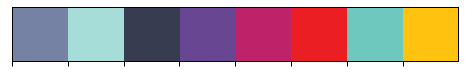

In [59]:
import math
from sklearn.metrics import r2_score
from atomsci.ddm.pipeline import diversity_plots as dp
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
# Create an array with the colors you want to use
colors = [
    "#7682A4",
    "#A7DDD8",
    "#373C50",
    "#694691",
    "#BE2369",
    "#EB1E23",
    "#6EC8BE",
    "#FFC30F",
]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
sns.palplot(pal)

In [60]:
# categorize data to plot correctly
if 'relation' in pred_df.columns:
    pred_df['censored']=pred_df[f'relation']
    pred_df.loc[pred_df.censored.isna(),'censored']='='
    relcat = CategoricalDtype(categories=["=","<", ">",], ordered=True)
    pred_df.censored=pred_df.censored.astype(relcat)
subcat = CategoricalDtype(categories=['train','valid','test'], ordered=True)
pred_df.subset = pred_df.subset.astype(subcat)

In [61]:
outdir=os.path.join(home_dir, 'Diversity_Plots_union_train_test_and_split/')
if not os.path.exists(outdir): 
    os.makedirs(outdir)

         dist subset
0    0.159420   test
1    0.387755   test
2    0.191176   test
3    0.297872   test
4    0.363636   test
..        ...    ...
820  0.188679  valid
821  0.338462  valid
822  0.532258  valid
823  0.354430  valid
824  0.230769  valid

[825 rows x 2 columns]


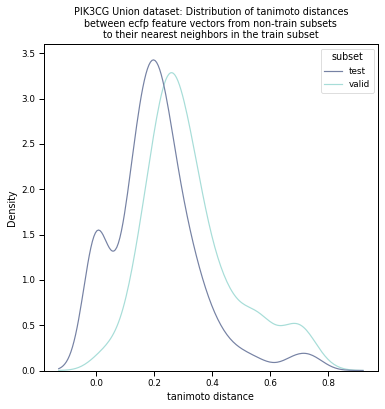

In [62]:
sns.set_context('paper')
#fig, ax = plt.subplots(1,1,figsize=(6,6))
#sns.kdeplot(data=pred_df, x='AD_index', hue='subset', common_norm=False, log_scale=True, ax=ax);
#ax.set_title('Distribution of AD indices among various subsets');
dists = dp.plot_tani_dist_distr(pred_df, 'base_rdkit_smiles', df_name=gene.upper()+' Union', subsets=True, out_dir=outdir)
print(dists)

In [63]:
!ls $outdir

In [64]:
train['subset']='train'
test['subset']='test'
pred_df=pd.concat([train,test])
pred_df
pred_df.subset.value_counts()

train    2611
test      428
Name: subset, dtype: int64

         dist subset
0    0.175439   test
1    0.145161   test
2    0.000000   test
3    0.268657   test
4    0.367347   test
..        ...    ...
423  0.387755   test
424  0.166667   test
425  0.129870   test
426  0.202532   test
427  0.183333   test

[428 rows x 2 columns]


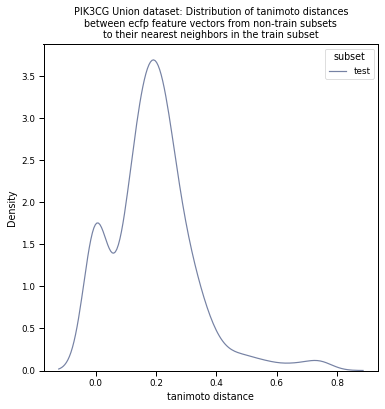

In [65]:
sns.set_context('paper')
dists = dp.plot_tani_dist_distr(pred_df, 'base_rdkit_smiles', df_name=gene.upper()+' Union', subsets=True, out_dir=outdir)
print(dists)

In [66]:
# import json
# #genes = ['CHRM1', 'CHRM2', 'CHRM3', 'CYP2C9', 'CYP2D6', 'CYP3A4', 'HRH1', 'KCNH2', 'PIK3CG'] #PIK3CG - model file name problem
# genes = ['CYP3A4'] 
# for gene in genes:
#     print(gene)
#     model_path = os.path.join(home_dir, gene.lower()+'_union_trainset_graphconv_ampl-1.1.0/')
#     print(os.listdir(model_path))
#     if gene == 'PIK3CG':
#         model_path = os.path.join(home_dir, gene.lower()+'_union_trainset_mordred_ampl-1.1.0/')
#     for l in os.listdir(model_path): print(l)
#     # extract model info from model_metadata.json file
#     with open(model_path + 'model_metadata.json') as json_file:
#         data = json.load(json_file)
#         print(data.keys())
#         print(data['model_parameters'])


In [67]:

    
#     # extract model info from model_metadata.json file
#     with open(model_extracted_dir + 'model_metadata.json') as json_file:
#         data = json.load(json_file)
#         #ampl_version = data['model_parameters']['ampl_version']
#         #featurizer = data['model_parameters']['featurizer']
#         #model_uuid = data['model_uuid']
#         split_uuid = data['splitting_parameters']['split_uuid']
# 	#get split file location
#         split_dir = os.path.dirname(data['training_dataset']['dataset_key'])
#         print(split_uuid, split_dir)


In [73]:
home_dir='/home/sarkart4/MoDaC/NCI_DOE_Archive/ATOM/Safety_Screen_Targets/'
#!ls $home_dir
genes = ['CHRM1', 'CHRM2', 'CHRM3', 'CYP2C9', 'CYP2D6', 'CYP3A4', 'HRH1', 'KCNH2', 'PIK3CG'] #PIK3CG - model file name problem
for gene in genes:
    print("\n", gene, "->", "Union")
    train=pd.read_csv(os.path.join(home_dir, gene.upper()+'-ampl-1.1.0/'+gene.lower()+'_union_trainset_base_smiles.csv'))
    test=pd.read_csv(os.path.join(home_dir, gene.upper()+'-ampl-1.1.0/'+gene.lower()+'_union_testset_base_smiles.csv'))
    train['subset']='train'
    test['subset']='test'
    split_file=[file for file in os.listdir(os.path.join(home_dir, gene.upper()+'-ampl-1.1.0/')) if file.startswith(gene.lower()+'_union_trainset_base_smiles_train_valid_test_')][0]
    split=pd.read_csv(home_dir+gene.upper()+'-ampl-1.1.0/'+split_file)
    # merge all info together and cut out feature columns
    pred_df=pd.concat([train,test])
    #pred_df=pred_df.merge(split, how='left', left_on='compound_id', right_on='cmpd_id')
    #pred_df.loc[pred_df.subset.isna(), 'subset']='test'
    print(pred_df.subset.value_counts())



 CHRM1 -> Union
train    1899
test      335
Name: subset, dtype: int64

 CHRM2 -> Union
train    1493
test      264
Name: subset, dtype: int64

 CHRM3 -> Union
train    1754
test      310
Name: subset, dtype: int64

 CYP2C9 -> Union
train    11321
test      1998
Name: subset, dtype: int64

 CYP2D6 -> Union
train    10445
test      1843
Name: subset, dtype: int64

 CYP3A4 -> Union
train    17796
test      3141
Name: subset, dtype: int64

 HRH1 -> Union
train    1077
test      189
Name: subset, dtype: int64

 KCNH2 -> Union
train    11920
test      2103
Name: subset, dtype: int64

 PIK3CG -> Union
train    2611
test      428
Name: subset, dtype: int64
